## Import

In [1]:
import os
import json
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import SyllableTokenizer
from lexicalrichness import LexicalRichness
from matplotlib.ticker import PercentFormatter


## Metrics

### Word and Character count

In [2]:
def get_words_count(text):
    words = word_tokenize(text)
    return len(words)

### Flesch Reading Ease

In [3]:
def calculate_FRE_score(text:str, lang:str="fr") -> float:
    """Calculate Flesch Reading Ease per sentence

    en: 206.835 - 1.015 * (total_words/total_sentences) - 84.6 * (total_syllabes/total_words) 
    fr: 207 - 1.015 * (total_words/total_sentences) - 73.6 * (total_syllabes/total_words) 

    Args:
        text (str): a given text
    """

    x = 206.835
    y = 84.6
    total_words = 0
    total_syllabes = 0
    SSP = SyllableTokenizer()

    if lang=="fr":
        x = 207
        y = 73.6

    sentences = sent_tokenize(text)
    total_sentences = len(sentences)

    for sentence in sentences:
        words = word_tokenize(sentence)
        total_words += len(words)

        for word in words:
            syllabes = SSP.tokenize(word)
            total_syllabes += len(syllabes)
     
    return x - 1.015 * (total_words/total_sentences) - y * (total_syllabes/total_words)

### Lexical Richness

In [4]:

def calculate_LR(text:str, lang:str="fr") -> float:
    try:
        lex = LexicalRichness(text)
        lr = lex.mtld()
    except:
        lr = 0
    return lr 
        


### Get metrics

In [5]:
def get_metrics_from_file(fpath, lang="fr"):
    fre_scores = []
    lr_scores = []
    word_count = []
    with open(fpath, "r", encoding="utf-8") as f:
        line = f.readline()
        while line:
            fre_scores.append(calculate_FRE_score(line, lang))
            lr_scores.append(calculate_LR(line, lang))
            word_count.append(get_words_count(line))
            line = f.readline()
            
    
    avg_fre_score = sum(fre_scores) / len(fre_scores)
    avg_lr_score = sum(lr_scores) / len(lr_scores)
    avg_word_count = sum(word_count) / len(word_count)

    return fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count

## Datasets

#### Alector

In [6]:

def alector(path="alector_aligned"):
    dic = {}
    for folder in os.listdir(path):
        folderpath = os.path.join(path, folder)
        text_type = folderpath.split("\\")[-1]

        for fname in os.listdir(folderpath):
            fpath = os.path.join(folderpath, fname)
            name, data_type = fname.split("_")
            name = name
            data_type = data_type.replace(".txt", "")
            if name not in dic.keys(): 
                dic[name] = {}
                dic[name]["text_type"] = text_type

            fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count = get_metrics_from_file(fpath)
            dic[name][data_type] = {}
            dic[name][data_type]["fre_scores"] = fre_scores
            dic[name][data_type]["avg_fre_score"] = avg_fre_score
            dic[name][data_type]["lr_scores"] = lr_scores
            dic[name][data_type]["avg_lr_score"] = avg_lr_score
            dic[name][data_type]["word_count"] = word_count
            dic[name][data_type]["avg_word_count"] = avg_word_count

    keys = dic.keys()
    sorted_keys = sorted(keys)
    sorted_dic = {}
    for key in sorted_keys:
        sorted_dic[key] = dic[key]

    with open('alector_metrics.json', 'w') as fp:
        json.dump(sorted_dic, fp)

    return sorted_dic



In [7]:
def alector_plot(dic, text_type:str, score:str, bins):
    
    source_avg = []
    target_avg = []
    x = []
    for item in dic:
        if dic[item]["text_type"] == text_type or text_type == "everything":
            source_avg += dic[item]["source"][score]
            target_avg += dic[item]["target"][score]

    print(len(source_avg), "ressources")

    plt.figure(figsize=(20,5))
    substracted = list()
    if score == "fre_scores":
        for tar_item, src_item in zip(target_avg, source_avg):
            substracted.append(tar_item - src_item)
        label = "target - source"

        plt.hist(substracted, label = label, bins=bins)

    if score == "lr_scores"  or score == "word_count":
        for tar_item, src_item in zip(target_avg, source_avg):
            substracted.append(src_item - tar_item)
        label = "source - target"

        plt.hist(substracted, label = label, bins=bins)
        
    plt.legend()
    plt.title(f"{score} score difference per file ({text_type}) - [{label}]")
    plt.show()


595 ressources


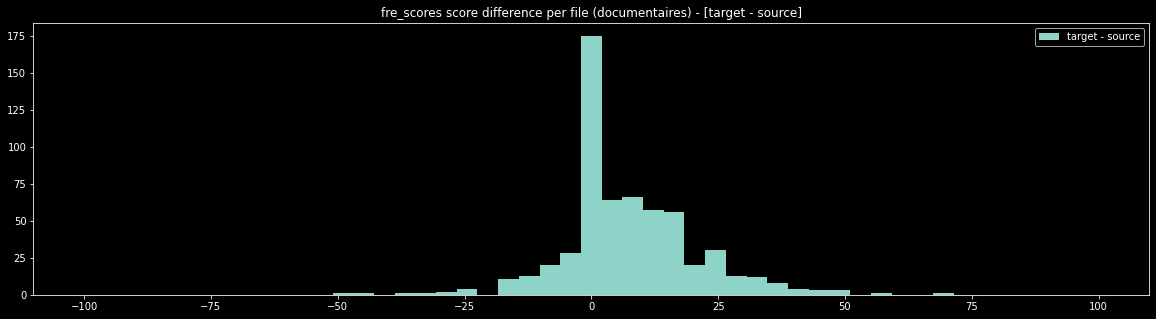

595 ressources


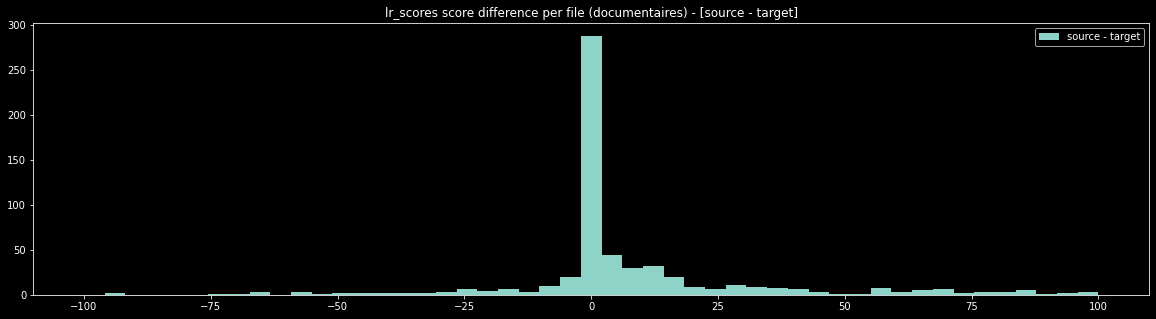

595 ressources


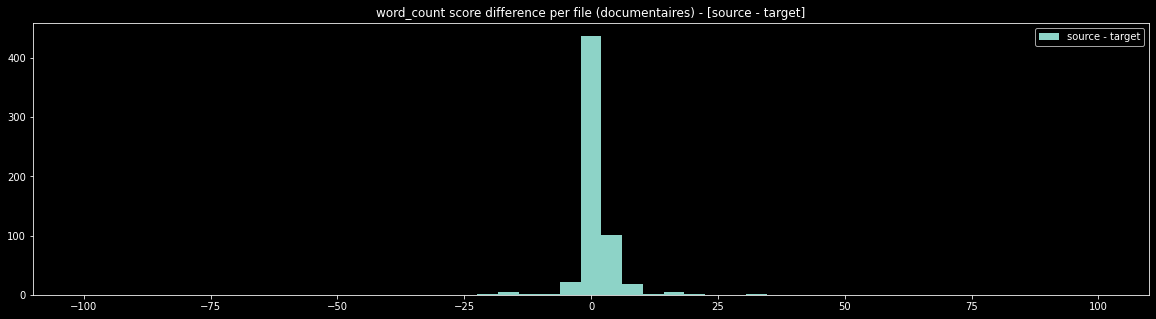

In [8]:
try:
    with open('alector_metrics.json', 'r') as fp:
        dic = json.load(fp)
except:
    dic = alector()

# text_types = ["contes", "documentaires", "everything"]
text_types = ["documentaires"]

for text_type in text_types:
    # Flesch Reading Ease
    alector_plot(dic, text_type, "fre_scores", numpy.linspace(-100, 100, 50))
    # Measure of Lexical Diversity (McCarthy 2005, McCarthy and Jarvis 2010)
    alector_plot(dic, text_type, "lr_scores", numpy.linspace(-100, 100, 50))
    # Word count
    alector_plot(dic, text_type, "word_count", numpy.linspace(-100, 100, 50))

#### Translated Datasets Comparisons

##### Loading & Plotting 

In [9]:
def load_dataset(path="translated_corpora/Turk-GEM", lang="en"):
    dic = {}
    for fname in os.listdir(path):
        fpath = os.path.join(path, fname)
        fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count = get_metrics_from_file(fpath, lang)
        dic[fname] = {}
        dic[fname]["fre_scores"] = fre_scores
        dic[fname]["avg_fre_score"] = avg_fre_score
        dic[fname]["lr_scores"] = lr_scores
        dic[fname]["avg_lr_score"] = avg_lr_score
        dic[fname]["word_count"] = word_count
        dic[fname]["avg_word_count"] = avg_word_count

    with open(path.split("/")[-1]+".json", 'w') as fp:
        json.dump(dic, fp)
    
    return dic

In [10]:
def retrieve_data_from_turk(dic, corpus_type, score):
    source = []
    target = []
    for key in dic.keys():
        if key.split(".")[0] == corpus_type:
            if key.split(".")[-1] == "norm":
                source = dic[key][score]
            else:
                target.append(dic[key][score])

    return source, target

def retrieve_data_from_asset(dic, corpus_type, score):
    source = []
    target = []
    for key in dic.keys():
        if key.split(".")[1] == corpus_type:
            if key.split(".")[-1] == "orig":
                source = dic[key][score]
            else:
                target.append(dic[key][score])

    return source, target

def retrieve_data_from_wikilarge(dic, corpus_type, score):
    source = []
    target = []
    for key in dic.keys():
        if key.split(".")[-2] == corpus_type:
            if key.split(".")[-1] == "src":
                source = dic[key][score]
            else:
                target = dic[key][score]

    return source, target


def dataset_plot(dic1, dic1name, dic2, dic2name, score, bins, dataset):
    dics = [dic1, dic2]
    dicsname = [dic1name, dic2name]

    plt.figure(figsize=(20,5))
    
    substracted = list()
    labels = list()
    c = 0
    for dic, dicname in zip(dics, dicsname):
        if dataset == "turk":
            val_src, val_tar = retrieve_data_from_turk(dic, "tune", score)
            test_src, test_tar = retrieve_data_from_turk(dic, "test", score)
        elif dataset == "asset":
            val_src, val_tar = retrieve_data_from_asset(dic, "valid", score)
            test_src, test_tar = retrieve_data_from_asset(dic, "test", score)
        elif dataset == "wikilarge":
            val_src, val_tar = retrieve_data_from_wikilarge(dic, "valid", score)
            test_src, test_tar = retrieve_data_from_wikilarge(dic, "test", score)
            train_src, train_tar = retrieve_data_from_wikilarge(dic, "train", score)

            src = val_src + test_src + train_src 
            tar = val_tar + test_tar + train_tar

        if dataset == "turk" or dataset == "asset":
            for count in range(len(val_tar)):
                val_tar[count] += test_tar[count]

            tar = val_tar 
            src = val_src + test_src
            tar_avg = []
            for i in range(len(tar)):
                for j in range(len(tar[i])):
                    if len(tar_avg) <= j:
                        tar_avg.append([])
                    tar_avg[j].append(tar[i][j])
                    
                    if len(tar_avg[j]) == len(tar):
                        tar_avg[j] = sum(tar_avg[j]) / len(tar)
        
            tar = tar_avg

        substracted.append([])

        if score == "fre_scores":
            for tar_item, src_item in zip(tar, src):
                substracted[c].append(tar_item - src_item)
            labels.append(f"target - source ({dicname})")

        if score == "lr_scores"  or score == "word_count":
            for tar_item, src_item in zip(tar, src):
                substracted[c].append(src_item - tar_item)
            labels.append(f"source - target ({dicname})")
        c += 1

    # plt.hist(substracted, bins=bins, label = labels, histtype='bar', density=True)
    sns.histplot(substracted, bins=bins, label = labels, multiple="dodge", stat="count")

    plt.legend()
    plt.title(f"{score} score difference per file ({text_type})")
    plt.show()


##### Turk

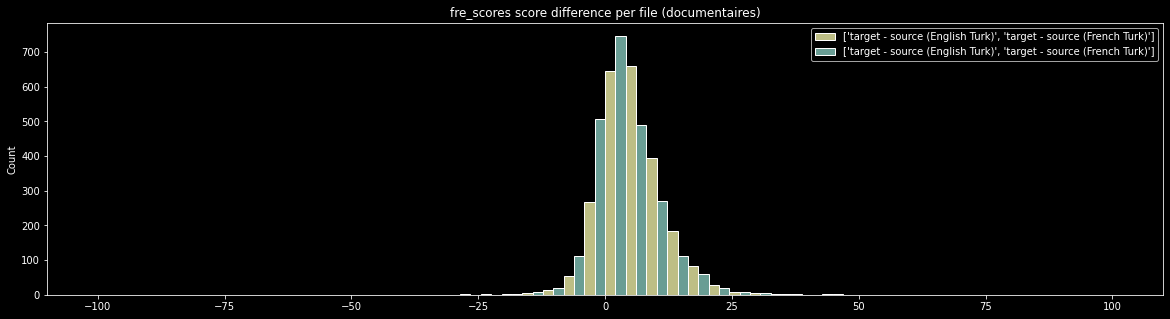

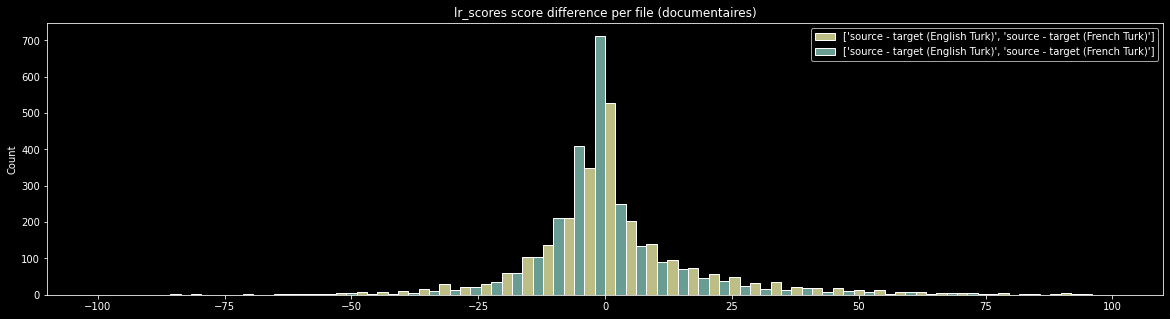

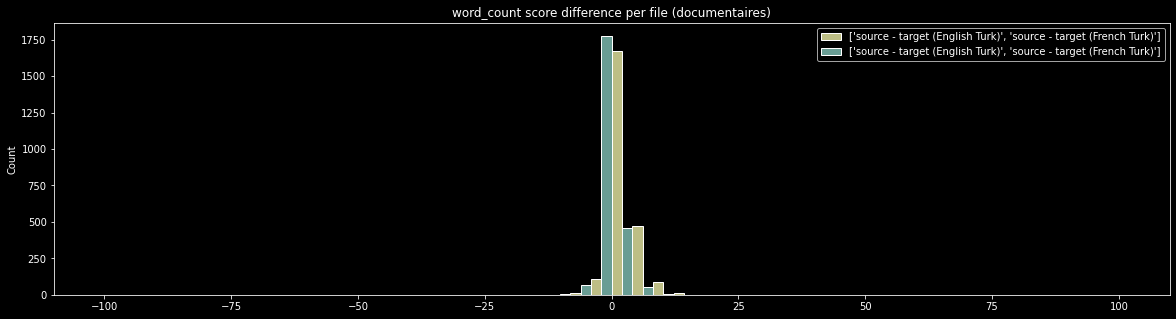

In [11]:
try:
    with open('Turk-GEM.json', 'r') as fp:
        dic_en = json.load(fp)
except:
    dic_en = load_dataset("translated_corpora/Turk-GEM")

try:
    with open('FR-Turk-GEM.json', 'r') as fp:
        dic_fr = json.load(fp)
except:
    dic_fr = load_dataset("translated_corpora/FR-Turk-GEM", 'fr')

metrics = ["fre_scores", "lr_scores", "word_count"]

for metric in metrics:
        dataset_plot(dic_en, "English Turk", dic_fr, "French Turk", metric, numpy.linspace(-100, 100, 50), "turk")


##### ASSET

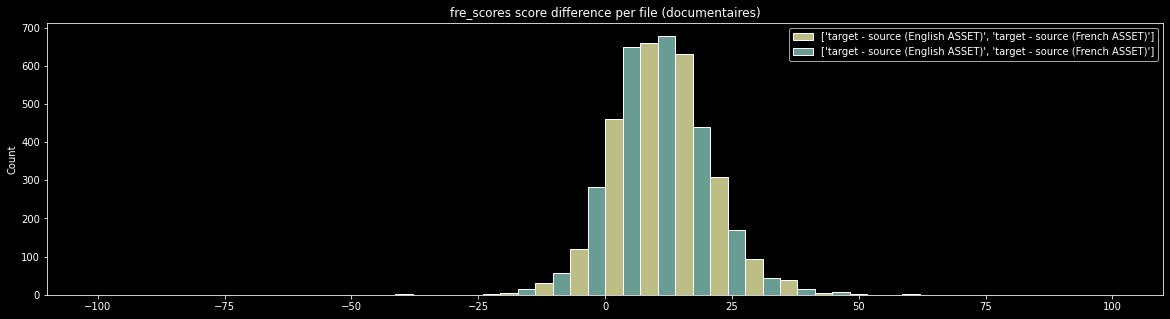

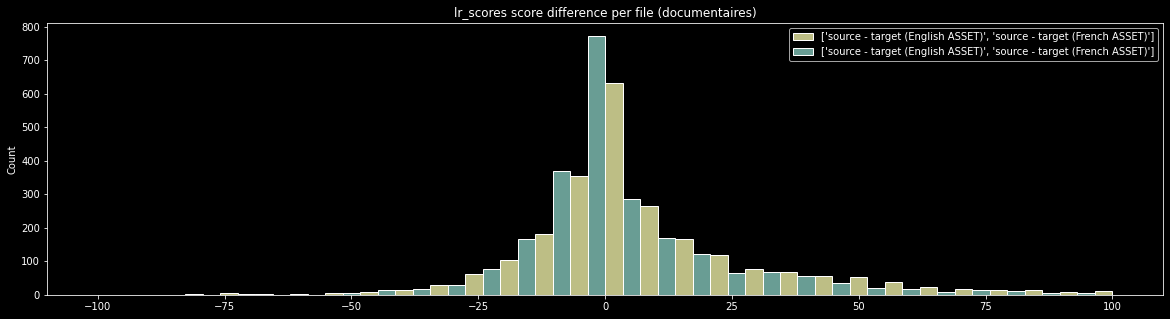

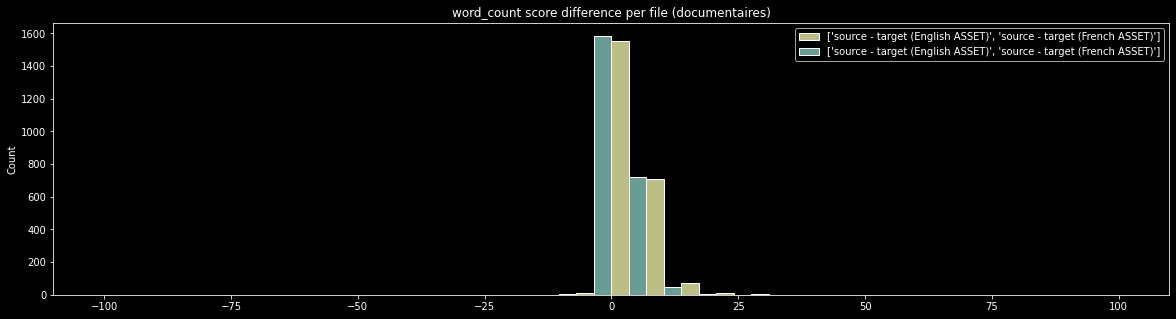

In [12]:
try:
    with open('ASSET.json', 'r') as fp:
        dic_en = json.load(fp)
except:
    dic_en = load_dataset("translated_corpora/ASSET")

try:
    with open('FR-ASSET.json', 'r') as fp:
        dic_fr = json.load(fp)
except:
    dic_fr = load_dataset("translated_corpora/FR-ASSET", 'fr')

metrics = ["fre_scores", "lr_scores", "word_count"]

for metric in metrics:
        dataset_plot(dic_en, "English ASSET", dic_fr, "French ASSET", metric, numpy.linspace(-100, 100, 30), "asset")

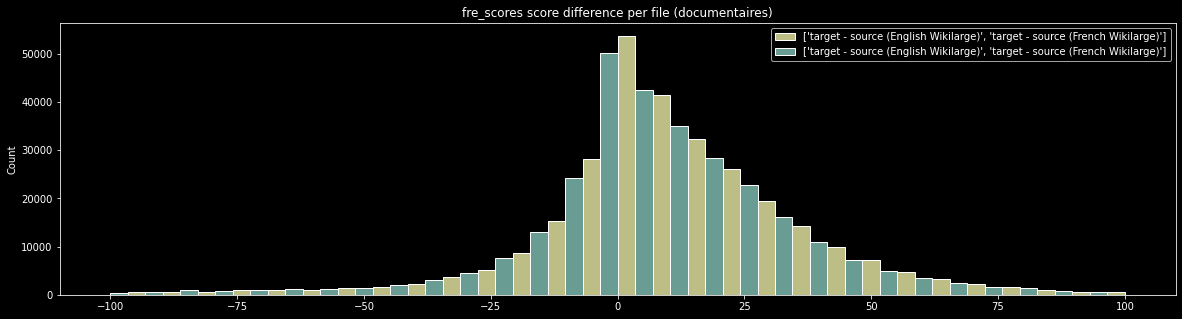

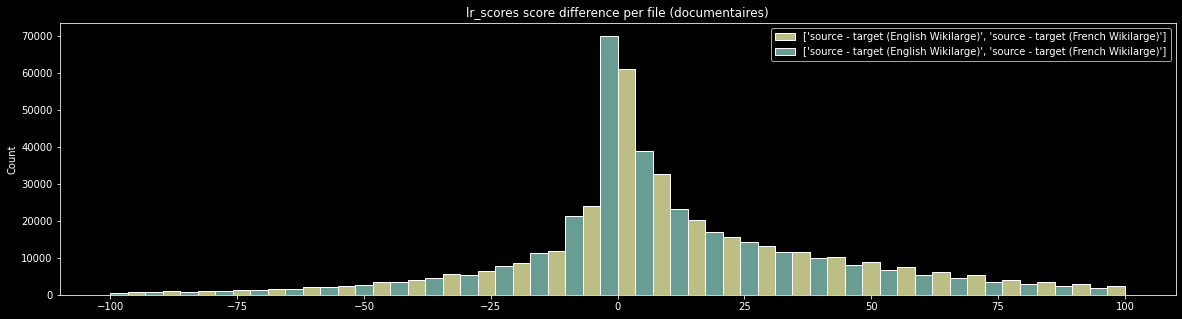

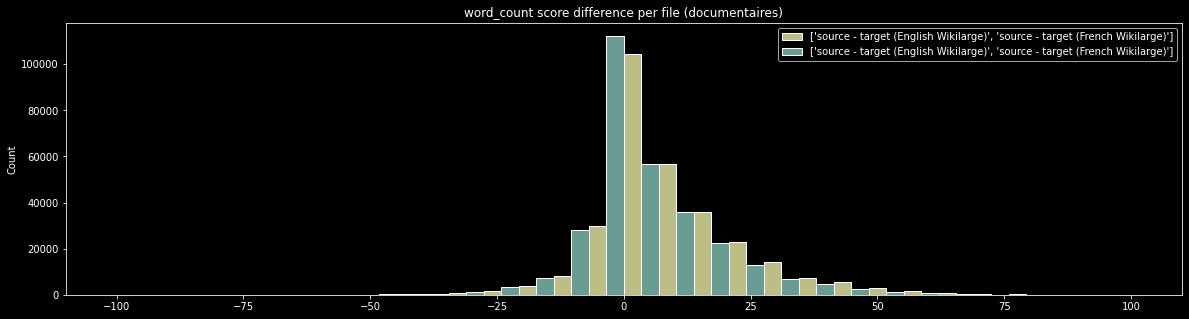

In [13]:
try:
    with open('wikilarge.json', 'r') as fp:
        dic_en = json.load(fp)
except:
    dic_en = load_dataset("translated_corpora/wikilarge")

try:
    with open('FR-wikilarge.json', 'r') as fp:
        dic_fr = json.load(fp)
except:
    dic_fr = load_dataset("translated_corpora/FR-wikilarge", 'fr')

metrics = ["fre_scores", "lr_scores", "word_count"]

for metric in metrics:
    dataset_plot(dic_en, "English Wikilarge", dic_fr, "French Wikilarge", metric, numpy.linspace(-100, 100, 30), "wikilarge")